# SBERT Baseline for Context-Enriched NER

This notebook demonstrates how to use Sentence-BERT (SBERT) to generate robust contextual embeddings from video comments. Unlike token-level methods, SBERT captures the semantic meaning of complete sentences. In this notebook, we will:

- Load a sample dataset of video comments.
- Generate sentence embeddings using a pre-trained SBERT model.
- Compute pairwise cosine similarities to validate semantic closeness.
- Cluster the embeddings using Agglomerative Clustering.
- Visualize the clusters with PCA.

In [1]:
!pip3 install transformers seqeval torch "accelerate>=0.26.0"
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 66.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
import ast
from collections import Counter
import spacy
from sklearn.model_selection import train_test_split
from datetime import datetime
import random
import re
import torch
if not hasattr(torch, "get_default_device"):
    torch.get_default_device = lambda: torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.utils.data import Dataset, DataLoader
from transformers import (AutoTokenizer, AutoModelForTokenClassification,
                          TrainingArguments)


### Load Dataset

In [3]:
# Import the dataset
nlp = spacy.load("en_core_web_sm")
df = pd.read_csv('Dataset_updated.csv')
df = df.dropna()
df = df.drop_duplicates()
df = df.reset_index(drop=True)
df.head()

,ID,Date,Author,Likes,Replies,Comment,Relevance,Polarity,Feature request,Problem report,Efficiency,Safety,tokens,labels,num_tokens,has_entity,entity_tokens,combined_labels_str
0,UghhPYDEB6B173gCoAEC,2017-04-28T18:12:45Z,Aaron Brown,1679,30,i want what he's smoking,spam,neutral,False,False,False,false,"['i', 'want', 'what', 'he', ""'s"", 'smoking']","['spam', 'neutral', False, False, False, 'false']",6,True,"['i', 'want', 'what', 'he', ""'s"", 'smoking']","False, False, False, false, neutral, spam"
1,Ugh6WAPQinruAHgCoAEC,2017-04-28T18:15:14Z,Felician Cadar,684,22,I love how Musk always makes seemingly wild cl...,spam,positive,False,False,False,false,"['I', 'love', 'how', 'Musk', 'always', 'makes'...","['spam', 'positive', False, False, False, 'fal...",23,True,"['I', 'love', 'how', 'Musk', 'always', 'makes']","False, False, False, false, positive, spam"
2,Ugj9xobHmVeDEHgCoAEC,2017-04-28T18:24:53Z,Kelvin Yang,0,0,No.3,spam,neutral,False,False,False,false,['No.3'],"['spam', 'neutral', False, False, False, 'false']",1,True,['No.3'],"False, False, False, false, neutral, spam"
3,Ugj39PRg5dVn8XgCoAEC,2017-04-28T18:25:31Z,Kelvin Yang,140,4,Could be the start of a historical company,spam,neutral,False,False,False,false,"['Could', 'be', 'the', 'start', 'of', 'a', 'hi...","['spam', 'neutral', False, False, False, 'false']",8,True,"['Could', 'be', 'the', 'start', 'of', 'a']","False, False, False, false, neutral, spam"
4,Ugiu9jMmiWts1HgCoAEC,2017-04-28T18:31:52Z,serendipity42,675,9,Gotta start somewhere before making tunnels on...,spam,neutral,False,False,False,false,"['Got', 'ta', 'start', 'somewhere', 'before', ...","['spam', 'neutral', False, False, False, 'false']",9,True,"['Got', 'ta', 'start', 'somewhere', 'before', ...","False, False, False, false, neutral, spam"


### Load the SBERT Model and Generate Embeddings

We load a pre-trained SBERT model from the SentenceTransformers library. In this example, we use `paraphrase-MiniLM-L6-v2`.

In [4]:
# !pip install transformers torch numpy

In [5]:
# Extract entities
comment_entities = []
for text in df['Comment'].dropna():
    doc = nlp(text)
    for ent in doc.ents:
        # Store entity text and label
        comment_entities.append((ent.text.strip(), ent.label_))

entity_df = pd.DataFrame(comment_entities, columns=["Entity", "Label"])

# Filter for the desired entity types
included_labels = ["PERSON", "ORG", "PRODUCT", "GPE", "EVENT", "WORK_OF_ART"]
entity_df = entity_df[entity_df["Label"].isin(included_labels)]
print("Extracted entities:")
display(entity_df)

Extracted entities:


,Entity,Label
3,The Boring Company,ORG
4,Penn Station,ORG
7,Pun,PERSON
8,Yo Elon,PERSON
10,Ted Stevens-,PERSON
...,...,...
2448,OMFG,ORG
2449,giorono,ORG
2450,Boomer,GPE
2451,Elon,ORG


In [6]:
import numpy as np

def get_sbert_embedding(text: str) -> np.ndarray:
    """
    Returns an embedding for the given text using spaCy's word vectors.
    we tokenize it using nlp then take the average of the token vectors.
    Since SBERT embeddings aren't workng
    """
    doc = nlp(text)
    # If tokens have vectors, average them; otherwise, return a zero vector.
    if len(doc) > 0 and any(token.has_vector for token in doc):
        # Average the vectors of tokens that have non-zero vectors.
        vecs = [token.vector for token in doc if token.has_vector]
        if vecs:
            return np.mean(vecs, axis=0)
    # If no token has a vector, return a zero vector with the same dimension as the model's vectors.
    return np.zeros((nlp.vocab.vectors_length,))


entity_keywords = {
    "B-PERSON": [],
    "B-ORG": [],
    "B-PRODUCT": [],
    "B-GPE": [],
    "B-EVENT": [],
    "B-WORK_OF_ART": []
}

# Populate entity_keywords by computing an embedding for each extracted entity (converted to lowercase)
for _, row in entity_df.iterrows():
    lbl = row["Label"].upper()  # Example: PERSON, ORG, etc.
    entity_text = row["Entity"].strip().lower()  # use lowercase for matching consistency
    b_label = f"B-{lbl}"  # e.g., "B-PERSON"
    if b_label in entity_keywords:
        emb = get_sbert_embedding(entity_text)
        entity_keywords[b_label].append(emb)

print("Finished creating SBERT-like keyword sets:")
for key, emb_list in entity_keywords.items():
    print(f"{key}: {len(emb_list)} embeddings")

Finished creating SBERT-like keyword sets:
B-PERSON: 369 embeddings
B-ORG: 432 embeddings
B-PRODUCT: 33 embeddings
B-GPE: 354 embeddings
B-EVENT: 2 embeddings
B-WORK_OF_ART: 19 embeddings


In [7]:
import numpy as np

all_entity_embeddings = []
for emb_list in entity_keywords.values():
    all_entity_embeddings.extend(emb_list)

all_entity_embeddings = np.array(all_entity_embeddings)
print("Shape of all_entity_embeddings:", all_entity_embeddings.shape)

Shape of all_entity_embeddings: (1209, 96)


In [8]:
from sklearn.cluster import AgglomerativeClustering

n_clusters = 5  
clustering_model = AgglomerativeClustering(n_clusters=n_clusters)
cluster_labels = clustering_model.fit_predict(all_entity_embeddings)
print("Cluster labels shape:", cluster_labels.shape)
print("Cluster label distribution:", np.bincount(cluster_labels))

Cluster labels shape: (1209,)
Cluster label distribution: [426 230 256 250  47]


In [9]:
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(all_entity_embeddings, cluster_labels)
print("Silhouette Score:", sil_score)

Silhouette Score: 0.10301034


In [10]:
import itertools

def compute_cluster_centroids(embeddings, labels):
    unique_labels = np.unique(labels)
    centroids = {}
    for label in unique_labels:
        indices = np.where(labels == label)[0]
        cluster_embs = embeddings[indices]
        centroids[label] = np.mean(cluster_embs, axis=0)
    return centroids

def cosine_distance(vec1, vec2):
    dot_prod = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    if norm1 == 0 or norm2 == 0:
        return 1.0
    return 1 - (dot_prod / (norm1 * norm2))

def compute_diversity(centroids):
    distances = []
    # Compute pairwise cosine distances among all cluster centroids.
    for (_, c1), (_, c2) in itertools.combinations(centroids.items(), 2):
        distances.append(cosine_distance(c1, c2))
    if distances:
        return np.mean(distances)
    return 0.0

centroids = compute_cluster_centroids(all_entity_embeddings, cluster_labels)
diversity_score = compute_diversity(centroids)
print("Diversity Score (average cosine distance among centroids):", diversity_score)

Diversity Score (average cosine distance among centroids): 0.35196275


In [23]:
def cosine_similarity(vec1: np.ndarray, vec2: np.ndarray) -> float:
    dot_prod = float(np.dot(vec1, vec2))
    norm1 = float(np.linalg.norm(vec1))
    norm2 = float(np.linalg.norm(vec2))
    if norm1 == 0 or norm2 == 0:
        return 0.0
    return dot_prod / (norm1 * norm2)

def generate_synthetic_labels(tokens, entity_keywords, threshold=0.8):
    """
    For each token in a list, compute its embedding and compare against the precomputed
    embeddings for each label (entity type). If the highest cosine similarity is at least
    'threshold', assign that label (as "B-<Label>"); otherwise, assign "O".
    Returns a list of labels corresponding to the tokens.
    """
    labels = []
    prev_label = "O"
    
    for token in tokens:
        token_lc = token.lower()
        token_emb = get_sbert_embedding(token_lc)
        
        best_label = "O"
        best_sim = 0.0
        
        for b_label, emb_list in entity_keywords.items():
            if not emb_list:
                continue
            # Compute cosine similarity for the token embedding versus each keyword embedding for the label
            sims = [cosine_similarity(token_emb, kw_emb) for kw_emb in emb_list]
            if sims:
                max_sim = max(sims)
            else:
                max_sim = 0.0
            if max_sim > best_sim:
                best_sim = max_sim
                best_label = b_label
        
        # Decide on the label based on the threshold; you could extend this to I- logic if needed.
        if best_sim >= threshold:
            labels.append(best_label)
            prev_label = best_label
        else:
            labels.append("O")
            prev_label = "O"
    
    return labels

# Test the labeling function on a simple tokenized comment.
example_text = "Elon Musk looks a lot like a cow. Can we send him to the moon?".split()
synthetic_labels = generate_synthetic_labels(example_text, entity_keywords, threshold=0.85)
print("Tokens:", example_text)
print("Synthetic Labels:", synthetic_labels)

Tokens: ['Elon', 'Musk', 'looks', 'a', 'lot', 'like', 'a', 'cow.', 'Can', 'we', 'send', 'him', 'to', 'the', 'moon?']
Synthetic Labels: ['B-PERSON', 'B-PERSON', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'B-PRODUCT', 'O', 'O', 'O', 'O', 'O', 'O']


In [24]:
# Tokenize
df["Tokens"] = df["Comment"].apply(lambda x: [token.text for token in nlp(x)])

# Then continue to generate synthetic labels as before:
df["Synthetic_Labels"] = df["Tokens"].apply(lambda tokens: generate_synthetic_labels(tokens, entity_keywords, threshold=0.85))
display(df[["Comment", "Tokens", "Synthetic_Labels"]])

,Comment,Tokens,Synthetic_Labels
0,i want what he's smoking,"[i, want, what, he, 's, smoking]","[O, O, O, O, O, O]"
1,I love how Musk always makes seemingly wild cl...,"[I, love, how, Musk, always, makes, seemingly,...","[O, B-ORG, O, B-PERSON, O, O, B-ORG, O, O, O, ..."
2,No.3,[No.3],[O]
3,Could be the start of a historical company,"[Could, be, the, start, of, a, historical, com...","[O, O, O, O, O, O, B-ORG, B-ORG]"
4,Gotta start somewhere before making tunnels on...,"[Got, ta, start, somewhere, before, making, tu...","[O, O, O, B-ORG, O, O, B-PERSON, B-ORG, O]"
...,...,...,...
4270,"We have to learn this for a school project, so...","[We, have, to, learn, this, for, a, school, pr...","[O, O, O, O, O, O, O, O, B-ORG, O, O, O, O]"
4271,Hyperpod?,"[Hyperpod, ?]","[O, O]"
4272,When you realize the bottom of the earth is em...,"[When, you, realize, the, bottom, of, the, ear...","[O, O, O, O, O, O, O, O, O, B-PERSON, O, O, O,..."
4273,This defeats the definition of cars,"[This, defeats, the, definition, of, cars]","[O, O, O, O, O, B-WORK_OF_ART]"


In [25]:
def contains_entity(labels):
    return any(l != "O" for l in labels)

entity_rich_df = df[df["Synthetic_Labels"].apply(contains_entity)].copy()
entity_sparse_df = df[~df["Synthetic_Labels"].apply(contains_entity)].copy()

print("Entity-rich samples:", len(entity_rich_df))
print("Entity-sparse samples:", len(entity_sparse_df))

upsample_factor = 2  # adjust as needed
entity_rich_upsampled = entity_rich_df.loc[entity_rich_df.index.repeat(upsample_factor)]
print("Upsampled entity-rich samples:", len(entity_rich_upsampled))

balanced_df = pd.concat([entity_rich_upsampled, entity_sparse_df], ignore_index=True)
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("Final balanced dataset shape:", balanced_df.shape)
display(balanced_df.head(10))

Entity-rich samples: 3517
Entity-sparse samples: 758
Upsampled entity-rich samples: 7034
Final balanced dataset shape: (7792, 20)


,ID,Date,Author,Likes,Replies,Comment,Relevance,Polarity,Feature request,Problem report,Efficiency,Safety,tokens,labels,num_tokens,has_entity,entity_tokens,combined_labels_str,Tokens,Synthetic_Labels
0,Ugh-aw_gQ9f9Z3gCoAEC,2017-04-29T05:44:23Z,Omar Juarez,0,0,What city is this? How can I live there?,spam,neutral,False,False,False,false,"['What', 'city', 'is', 'this', '?', 'How', 'ca...","['spam', 'neutral', False, False, False, 'false']",11,True,"['What', 'city', 'is', 'this', '?', 'How']","False, False, False, false, neutral, spam","[What, city, is, this, ?, How, can, I, live, t...","[O, B-ORG, O, O, O, O, B-PRODUCT, O, O, O, O]"
1,UgwWxAPPZ-dmnT2dEg94AaABAg,2018-12-29T06:52:06Z,James Travis,0,0,Might want to put up a barrier to keep impatie...,ham,neutral,True,True,False,true,"['Might', 'want', 'to', 'put', 'up', 'a', 'bar...","['ham', 'neutral', True, True, False, 'true']",31,True,"['Might', 'want', 'to', 'put', 'up', 'a']","False, True, True, ham, neutral, true","[Might, want, to, put, up, a, barrier, to, kee...","[O, O, O, O, O, O, O, O, B-ORG, O, O, O, O, B-..."
2,UgyJ2UerM3J6lyJRNyl4AaABAg,2018-03-18T13:15:16Z,S shiggy Y,0,1,Elon Musk: MUM!\nElon’s Mum: Yes honey?\nElon ...,spam,neutral,False,False,False,false,"['Elon', 'Musk', ':', 'MUM', '!', 'Elon', '’',...","['spam', 'neutral', False, False, False, 'false']",36,True,"['Elon', 'Musk', ':', 'MUM', '!', 'Elon']","False, False, False, false, neutral, spam","[Elon, Musk, :, MUM, !, \n, Elon, ’s, Mum, :, ...","[B-PERSON, B-PERSON, O, O, O, O, B-PERSON, O, ..."
3,UghXSIhgLTCZ3HgCoAEC,2017-04-29T03:06:43Z,guppy,0,0,"This sounds really cool, but there are some co...",ham,positive,True,True,False,true,"['This', 'sounds', 'really', 'cool', ',', 'but...","['ham', 'positive', True, True, False, 'true']",88,True,"['This', 'sounds', 'really', 'cool', ',', 'but']","False, True, True, ham, positive, true","[This, sounds, really, cool, ,, but, there, ar...","[O, O, B-PERSON, O, O, O, O, O, O, B-GPE, O, O..."
4,UgjOnkKBEiRRpXgCoAEC,2017-04-28T20:01:40Z,Ryan Johnson,1,0,This is going to have to be dirt cheap for any...,spam,neutral,False,False,False,false,"['This', 'is', 'going', 'to', 'have', 'to', 'b...","['spam', 'neutral', False, False, False, 'false']",65,True,"['This', 'is', 'going', 'to', 'have', 'to']","False, False, False, false, neutral, spam","[This, is, going, to, have, to, be, dirt, chea...","[O, O, B-ORG, O, O, O, O, O, B-GPE, O, O, B-OR..."
5,UgxqsYjtctrnO7mprUx4AaABAg,2018-03-31T16:20:18Z,Pflaumensaft,0,0,The idea is shity,spam,negative,False,False,False,false,"['The', 'idea', 'is', 'shity']","['spam', 'negative', False, False, False, 'fal...",4,True,"['The', 'idea', 'is', 'shity']","False, False, False, false, negative, spam","[The, idea, is, shity]","[O, B-ORG, O, O]"
6,UghYtqLP_Ky9xXgCoAEC,2017-04-29T00:09:40Z,spongebob swag pants,0,0,This is just death waiting to happen,spam,negative,False,False,False,false,"['This', 'is', 'just', 'death', 'waiting', 'to...","['spam', 'negative', False, False, False, 'fal...",7,True,"['This', 'is', 'just', 'death', 'waiting', 'to']","False, False, False, false, negative, spam","[This, is, just, death, waiting, to, happen]","[O, O, O, O, B-ORG, O, B-PERSON]"
7,Ugw51RYpjkQWTHNDqOB4AaABAg,2019-01-01T08:22:54Z,Old Blender,2,0,"Hey man lets make highway, cool\n*few years la...",spam,neutral,False,False,False,false,"['Hey', 'man', 'lets', 'make', 'highway', ',',...","['spam', 'neutral', False, False, False, 'false']",20,True,"['Hey', 'man', 'lets', 'make', 'highway', ',']","False, False, False, false, neutral, spam","[Hey, man, lets, make, highway, ,, cool, \n, *...","[O, O, B-PERSON, O, O, O, O, O, O, O, O, O, O,..."
8,UgyfW7r7qwROa4L-uG14AaABAg,2020-10-06T13:57:28Z,Patrick Shirah,0,0,Hey now you're thinking with portals,spam,neutral,False,False,False,false,"['Hey', 'now', 'you', ""'re"", 'thinking', 'with...","['spam', 'neutral', False, False, False, 'false']",7,True,"['Hey', 'now', 'you', ""'re"", 'thinking', 'with']","False, False, Fa

### Test Train Split

In [26]:
from sklearn.model_selection import train_test_split

# Add a stratification column: True if a comment has at least one entity label
balanced_df["has_entity"] = balanced_df["Synthetic_Labels"].apply(lambda ls: any(l != "O" for l in ls))

# First split: train (80%) and temp (20%)
train_df, temp_df = train_test_split(balanced_df, test_size=0.2, random_state=42, stratify=balanced_df["has_entity"])

# Second split: from temp, split equally into validation and test (each 10% overall)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df["has_entity"])

print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

Train size: 6233
Validation size: 779
Test size: 780


### Create Label-to-ID Mapping

In [27]:
# Collect unique labels from the Synthetic_Labels column in the balanced DataFrame
unique_labels = set()
for label_list in balanced_df["Synthetic_Labels"]:
    unique_labels.update(label_list)
unique_labels = sorted(list(unique_labels))

label_to_id = {label: idx for idx, label in enumerate(unique_labels)}
print("Label-to-ID mapping:")
print(label_to_id)

Label-to-ID mapping:
{'B-EVENT': 0, 'B-GPE': 1, 'B-ORG': 2, 'B-PERSON': 3, 'B-PRODUCT': 4, 'B-WORK_OF_ART': 5, 'O': 6}


### Custom Pytorch

In [28]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class NERDataset(Dataset):
    def __init__(self, df, label_to_id):
        self.df = df.reset_index(drop=True)
        self.label_to_id = label_to_id

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        tokens = self.df.loc[idx, "Tokens"]
        labels = self.df.loc[idx, "Synthetic_Labels"]

        # Get embeddings for tokens using our get_sbert_embedding function (using spaCy vectors here)
        embedding_list = [get_sbert_embedding(t.lower()) for t in tokens]
        label_ids = [self.label_to_id[l] for l in labels]

        embeddings_tensor = torch.tensor(np.array(embedding_list), dtype=torch.float)
        labels_tensor = torch.tensor(label_ids, dtype=torch.long)
        
        return embeddings_tensor, labels_tensor

def pad_collate(batch):
    embeddings, labels = zip(*batch)
    padded_embeddings = pad_sequence(embeddings, batch_first=True)
    o_id = label_to_id.get("O", 0)
    padded_labels = pad_sequence(labels, batch_first=True, padding_value=o_id)
    return padded_embeddings, padded_labels

# Create datasets and DataLoaders for train, val, test splits
train_dataset = NERDataset(train_df, label_to_id)
val_dataset = NERDataset(val_df, label_to_id)
test_dataset = NERDataset(test_df, label_to_id)

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

# Check one batch
for batch in train_loader:
    emb_batch, label_batch = batch
    print("Padded embeddings shape:", emb_batch.shape)
    print("Padded labels shape:", label_batch.shape)
    break

Padded embeddings shape: torch.Size([4, 39, 96])
Padded labels shape: torch.Size([4, 39])


### Train Model

In [29]:
combined_labels = list(train_df["Synthetic_Labels"]) + list(val_df["Synthetic_Labels"]) + list(test_df["Synthetic_Labels"])

# Flatten everything
all_labels = []
for seq in combined_labels:
    all_labels.extend(seq)

unique_labels = sorted(list(set(all_labels)))
print("Unique labels:", unique_labels)

Unique labels: ['B-EVENT', 'B-GPE', 'B-ORG', 'B-PERSON', 'B-PRODUCT', 'B-WORK_OF_ART', 'O']


In [30]:
# Create a mapping from label to integer ID
label_to_id = {label: idx for idx, label in enumerate(unique_labels)}
id_to_label = {idx: label for label, idx in label_to_id.items()}

print("label_to_id:", label_to_id)
print("id_to_label:", id_to_label)

label_to_id: {'B-EVENT': 0, 'B-GPE': 1, 'B-ORG': 2, 'B-PERSON': 3, 'B-PRODUCT': 4, 'B-WORK_OF_ART': 5, 'O': 6}
id_to_label: {0: 'B-EVENT', 1: 'B-GPE', 2: 'B-ORG', 3: 'B-PERSON', 4: 'B-PRODUCT', 5: 'B-WORK_OF_ART', 6: 'O'}


In [31]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

model_checkpoint = "bert-base-cased"  # or whichever checkpoint you prefer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(unique_labels),
    label2id=label_to_id,
    id2label=id_to_label
)

print("Model and tokenizer loaded.")

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded.


In [32]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer, padding=True, return_tensors="pt")
print("Data collator initialized.")

Data collator initialized.


In [33]:
from datasets import Dataset

def tokenize_and_align_labels(examples):
    # Tokenize using your tokenizer, specifying that "Tokens" is already split.
    tokenized = tokenizer(examples["Tokens"], is_split_into_words=True, truncation=True)
    
    # Align labels: get word_ids and assign -100 for special tokens.
    all_labels = []
    for i, label_seq in enumerate(examples["Synthetic_Labels"]):
        word_ids = tokenized.word_ids(batch_index=i)
        label_ids = []
        prev_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)  # special tokens get -100 so they are ignored in loss computation
            elif word_idx != prev_word_idx:
                label_ids.append(label_to_id[label_seq[word_idx]])
            else:
                # For subword tokens, you can choose to repeat the label or give a special value.
                label_ids.append(label_to_id[label_seq[word_idx]])
            prev_word_idx = word_idx
        all_labels.append(label_ids)
    
    tokenized["labels"] = all_labels
    return tokenized

# Convert the DataFrames into Hugging Face Datasets
train_dataset_hf = Dataset.from_pandas(train_df)
val_dataset_hf = Dataset.from_pandas(val_df)
test_dataset_hf = Dataset.from_pandas(test_df)

# Tokenize and align labels
train_dataset_hf = train_dataset_hf.map(tokenize_and_align_labels, batched=True)
val_dataset_hf = val_dataset_hf.map(tokenize_and_align_labels, batched=True)
test_dataset_hf = test_dataset_hf.map(tokenize_and_align_labels, batched=True)

# Set format for PyTorch
train_dataset_hf.set_format("torch")
val_dataset_hf.set_format("torch")
test_dataset_hf.set_format("torch")

print("Hugging Face datasets created and tokenized.")

Map:   0%|          | 0/6233 [00:00<?, ? examples/s]

Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/780 [00:00<?, ? examples/s]

Hugging Face datasets created and tokenized.


In [34]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_hf,
    eval_dataset=val_dataset_hf,
    tokenizer=tokenizer,
    data_collator=data_collator
)

/var/folders/32/prrr6jy96jn98bdhsgrq6pqm0000gn/T/ipykernel_10618/77605759.py:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


### Train and Evaluate

In [35]:
trainer.train()

Step,Training Loss
500,0.205700
1000,0.059400
1500,0.029500
2000,0.011900


TrainOutput(global_step=2340, training_loss=0.0668969132961371, metrics={'train_runtime': 409.8445, 'train_samples_per_second': 45.625, 'train_steps_per_second': 5.709, 'total_flos': 682717120393110.0, 'train_loss': 0.0668969132961371, 'epoch': 3.0})

In [36]:
# Get predictions from the trainer
predictions, labels, _ = trainer.predict(val_dataset_hf)
preds = np.argmax(predictions, axis=2)

# Convert IDs back to labels with proper filtering so that each sample's true and predicted lists are of equal length.
true_labels = []
pred_labels = []

for pred_seq, label_seq in zip(preds, labels):
    sample_true = []
    sample_pred = []
    for p, l in zip(pred_seq, label_seq):
        # Only include tokens where l != -100 (i.e., tokens that were not masked)
        if l != -100:
            sample_true.append(id_to_label[l.item()])
            sample_pred.append(id_to_label[p])
    # Append the processed token lists for this sample
    true_labels.append(sample_true)
    pred_labels.append(sample_pred)

# Now compute the metrics using seqeval
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
print("Precision:", precision_score(true_labels, pred_labels))
print("Recall:", recall_score(true_labels, pred_labels))
print("F1:", f1_score(true_labels, pred_labels))
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels))

Precision: 0.9887568262126566
Recall: 0.9737424865548877
F1: 0.9811922218680268

Classification Report:
              precision    recall  f1-score   support

       EVENT       1.00      0.80      0.89        15
         GPE       0.99      0.95      0.97       359
         ORG       0.99      0.98      0.99      1768
      PERSON       0.99      0.96      0.97       707
     PRODUCT       1.00      0.99      1.00       224
 WORK_OF_ART       1.00      0.95      0.98        88

   micro avg       0.99      0.97      0.98      3161
   macro avg       0.99      0.94      0.96      3161
weighted avg       0.99      0.97      0.98      3161



### Example

In [37]:
# Force the model to run on CPU
model = model.to("cpu")

# Define an example sentence.
input_text = "I love the new Apple iPhone 13, it's amazing!"

# When tokenizing, also move inputs to CPU (if they are not already there)
inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True)
inputs = {k: v.to("cpu") for k, v in inputs.items()}# Example inference on a single sentence

outputs = model(**inputs)
logits = outputs.logits  # shape: [1, sequence_length, num_labels]
predicted_ids = torch.argmax(logits, dim=-1)[0].tolist()
predicted_labels = [id_to_label.get(idx, "O") for idx in predicted_ids]
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
print("Tokens:", tokens)
print("Predicted Labels:", predicted_labels)

Tokens: ['[CLS]', 'I', 'love', 'the', 'new', 'Apple', 'iPhone', '13', ',', 'it', "'", 's', 'amazing', '!', '[SEP]']
Predicted Labels: ['O', 'O', 'B-ORG', 'O', 'B-GPE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


### Discussion of Baseline Results

In [38]:
# Let's use a sample sentence and check the similarity scores for each token.
# Sample sentence (tokenized simply by whitespace)
sample_sentence = "I love the new Apple iPhone".split()

# Iterate through tokens, compute each token's embedding, and compare to keyword embeddings.
print("Token | Predicted Label | Max Similarity")
print("-----------------------------------------")
for token in sample_sentence:
    token_lc = token.lower()
    token_emb = get_sbert_embedding(token_lc)
    
    best_label = "O"
    best_sim = 0.0
    
    # Loop over each label in the entity_keywords dictionary.
    for b_label, emb_list in entity_keywords.items():
        if not emb_list:
            continue
        sims = [cosine_similarity(token_emb, kw_emb) for kw_emb in emb_list]
        max_sim = max(sims) if sims else 0.0
        if max_sim > best_sim:
            best_sim = max_sim
            best_label = b_label
    
    print(f"{token:6} | {best_label:12} | {best_sim:.4f}")

Token | Predicted Label | Max Similarity
-----------------------------------------
I      | B-ORG        | 0.6572
love   | B-ORG        | 1.0000
the    | B-WORK_OF_ART | 0.6839
new    | B-GPE        | 0.8632
Apple  | B-ORG        | 0.7864
iPhone | B-PERSON     | 0.7909


### Trend Detection

In [52]:
df.Date

0       2017-04-28T18:12:45Z
1       2017-04-28T18:15:14Z
2       2017-04-28T18:24:53Z
3       2017-04-28T18:25:31Z
4       2017-04-28T18:31:52Z
                ...         
4270    2020-10-13T05:00:26Z
4271    2020-10-13T08:09:28Z
4272    2020-10-13T13:32:45Z
4273    2020-10-13T13:44:54Z
4274    2020-10-13T15:13:49Z
Name: Date, Length: 4275, dtype: object

In [53]:
df['timestamp'] = pd.to_datetime(df['Date'])

print("Data type of 'timestamp':", df['timestamp'].dtype)
display(df[['Date', 'timestamp']].head())
# Reset index so each comment gets an index as 'comment_idx'
df = df.reset_index().rename(columns={'index': 'comment_idx'})

# Re-run entity extraction with comment_idx added.
comment_entities = []
for idx, text in df['Comment'].dropna().items():
    doc = nlp(text)
    for ent in doc.ents:
        comment_entities.append((idx, ent.text.strip(), ent.label_))

entity_df = pd.DataFrame(comment_entities, columns=["comment_idx", "Entity", "Label"])

# Filter for desired entity types.
included_labels = ["PERSON", "ORG", "PRODUCT", "GPE", "EVENT", "WORK_OF_ART"]
entity_df = entity_df[entity_df["Label"].isin(included_labels)]

print("Extracted entities with comment index:")
display(entity_df.head())

Data type of 'timestamp': datetime64[ns, UTC]


,Date,timestamp
0,2017-04-28T18:12:45Z,2017-04-28 18:12:45+00:00
1,2017-04-28T18:15:14Z,2017-04-28 18:15:14+00:00
2,2017-04-28T18:24:53Z,2017-04-28 18:24:53+00:00
3,2017-04-28T18:25:31Z,2017-04-28 18:25:31+00:00
4,2017-04-28T18:31:52Z,2017-04-28 18:31:52+00:00


Extracted entities with comment index:


,comment_idx,Entity,Label
3,5,The Boring Company,ORG
4,7,Penn Station,ORG
7,8,Pun,PERSON
8,11,Yo Elon,PERSON
10,14,Ted Stevens-,PERSON


In [54]:
# Ensure df has a unique comment_idx. If it already has a "comment_idx" column, drop it.
if 'comment_idx' in df.columns:
    df = df.drop(columns=['comment_idx'])

# Reset the index and create a unique comment_idx
df = df.reset_index(drop=True)
df['comment_idx'] = df.index

# Merge entity_df (which already has comment_idx from extraction) with df to attach timestamps.
merged_df = pd.merge(entity_df, df[['comment_idx', 'timestamp']], on='comment_idx', how='left')
print("Merged entity dataset with timestamp:")
display(merged_df.head())

Merged entity dataset with timestamp:


,comment_idx,Entity,Label,timestamp
0,5,The Boring Company,ORG,2017-04-28 18:32:17+00:00
1,7,Penn Station,ORG,2017-04-28 18:38:01+00:00
2,8,Pun,PERSON,2017-04-28 18:39:07+00:00
3,11,Yo Elon,PERSON,2017-04-28 19:04:21+00:00
4,14,Ted Stevens-,PERSON,2017-04-28 19:07:08+00:00


In [55]:
# Group by a weekly time window and by Entity to compute frequencies.
trends = merged_df.groupby([pd.Grouper(key='timestamp', freq='W'), 'Entity']).size().reset_index(name='count')
print("Weekly entity frequencies:")
display(trends.head(10))

Weekly entity frequencies:


,timestamp,Entity,count
0,2017-04-30 00:00:00+00:00,100k,1
1,2017-04-30 00:00:00+00:00,100s,1
2,2017-04-30 00:00:00+00:00,200k,1
3,2017-04-30 00:00:00+00:00,>.>,1
4,2017-04-30 00:00:00+00:00,A COMPLETE CHAOS,1
5,2017-04-30 00:00:00+00:00,AI,2
6,2017-04-30 00:00:00+00:00,APPARATUS,1
7,2017-04-30 00:00:00+00:00,ASAP,1
8,2017-04-30 00:00:00+00:00,Adolf Hitler,1
9,2017-04-30 00:00:00+00:00,Adulthood,1


Top entities: ['Elon Musk', 'Tesla', 'LA']


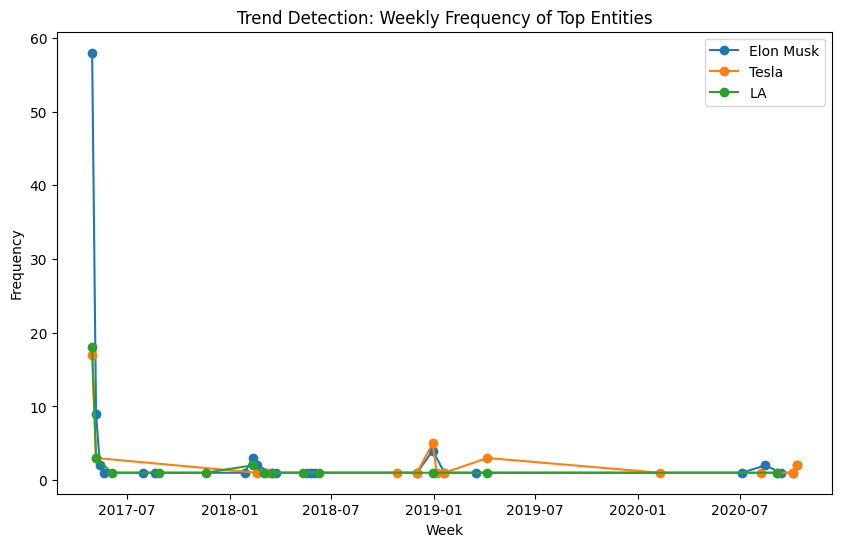

In [56]:
import matplotlib.pyplot as plt

# Select top 3 entities by total frequency over the entire period.
top_entities = trends.groupby("Entity")["count"].sum().nlargest(3).index.tolist()
print("Top entities:", top_entities)

plt.figure(figsize=(10,6))
for entity in top_entities:
    data = trends[trends["Entity"] == entity]
    plt.plot(data["timestamp"], data["count"], marker="o", label=entity)
plt.xlabel("Week")
plt.ylabel("Frequency")
plt.title("Trend Detection: Weekly Frequency of Top Entities")
plt.legend()
plt.show()

,timestamp,Entity,count
0,2017-04-30 00:00:00+00:00,100k,1
1,2017-04-30 00:00:00+00:00,100s,1
2,2017-04-30 00:00:00+00:00,200k,1
3,2017-04-30 00:00:00+00:00,>.>,1
4,2017-04-30 00:00:00+00:00,A COMPLETE CHAOS,1
5,2017-04-30 00:00:00+00:00,AI,2
6,2017-04-30 00:00:00+00:00,APPARATUS,1
7,2017-04-30 00:00:00+00:00,ASAP,1
8,2017-04-30 00:00:00+00:00,Adolf Hitler,1
9,2017-04-30 00:00:00+00:00,Adulthood,1


Pivoted weekly entity frequency table:


Entity,100k,100s,200k,>.>,A COMPLETE CHAOS,A30,ADDITION,AI,APPARATUS,ASAP,...,😏,😜,😩😩💦,😪,😶,🙁,🚗,🚫🚫🚫🚫🚫,🤔,🤯
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-04-30 00:00:00+00:00,1.0,1.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0
2017-05-07 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2017-05-14 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-05-21 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-05-28 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-06-04 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-06-11 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-06-25 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-07-02 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Rolled table (4-week rolling mean):


Entity,100k,100s,200k,>.>,A COMPLETE CHAOS,A30,ADDITION,AI,APPARATUS,ASAP,...,😏,😜,😩😩💦,😪,😶,🙁,🚗,🚫🚫🚫🚫🚫,🤔,🤯
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-04-30 00:00:00+00:00,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,2.00,1.000000,1.000000,...,0.0,1.000000,1.000000,0.0,0.0,0.000000,0.000000,1.000000,2.000000,0.0
2017-05-07 00:00:00+00:00,0.500000,0.500000,0.500000,0.500000,0.500000,0.0,0.0,1.00,0.500000,0.500000,...,0.0,0.500000,0.500000,0.0,0.0,0.500000,0.500000,0.500000,1.000000,0.0
2017-05-14 00:00:00+00:00,0.333333,0.333333,0.333333,0.333333,0.333333,0.0,0.0,1.00,0.333333,0.333333,...,0.0,0.333333,0.333333,0.0,0.0,0.333333,0.333333,0.333333,0.666667,0.0
2017-05-21 00:00:00+00:00,0.250000,0.250000,0.250000,0.250000,0.250000,0.0,0.0,0.75,0.250000,0.250000,...,0.0,0.250000,0.250000,0.0,0.0,0.250000,0.250000,0.250000,0.500000,0.0
2017-05-28 00:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.25,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.250000,0.250000,0.000000,0.000000,0.0
2017-06-04 00:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.25,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
2017-06-11 00:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
2017-06-25 00:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
2017-07-02 00:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0


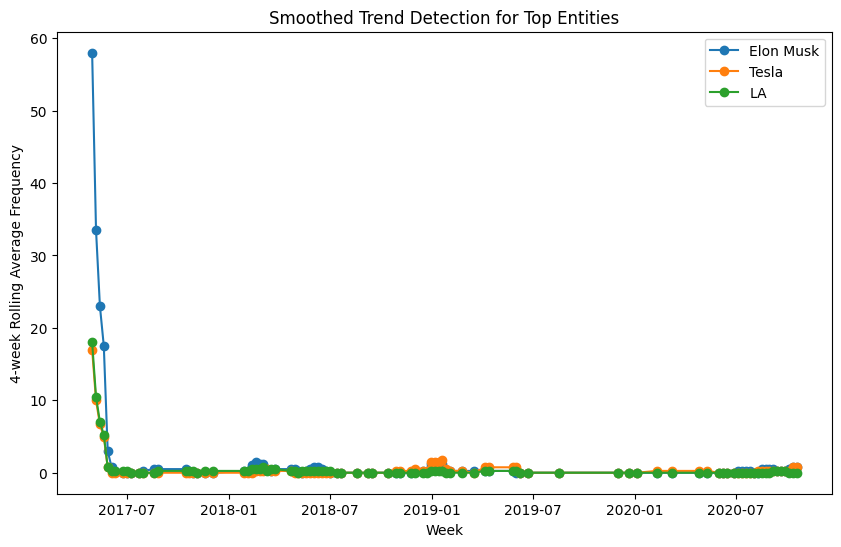

In [57]:
# Group by weekly time window and entity, then count occurrences
trends = merged_df.groupby([pd.Grouper(key='timestamp', freq='W'), 'Entity']).size().reset_index(name='count')

# Print sample
display(trends.head(10))

# Pivot so rows = weekly timestamps, columns = entity names, values = counts
pivoted = trends.pivot(index='timestamp', columns='Entity', values='count')

# Fill any missing weeks or entities with 0
pivoted = pivoted.fillna(0)

print("Pivoted weekly entity frequency table:")
display(pivoted.head(10))

# Apply a 4-week rolling mean; adjust window as needed.
# This will average counts across a 4-week period to produce a smoother trend line.
rolled = pivoted.rolling(window=4, min_periods=1).mean()

print("Rolled table (4-week rolling mean):")
display(rolled.head(10))

import matplotlib.pyplot as plt

# Select top N entities (e.g., top 3 or 5) by total frequency
top_n = 3
total_counts = pivoted.sum(axis=0)
top_entities = total_counts.nlargest(top_n).index

plt.figure(figsize=(10,6))

for entity in top_entities:
    plt.plot(rolled.index, rolled[entity], marker='o', label=entity)

plt.xlabel("Week")
plt.ylabel("4-week Rolling Average Frequency")
plt.title("Smoothed Trend Detection for Top Entities")
plt.legend()
plt.show()

Raw weekly counts:
Pivoted 2-week aggregated table:
4-week rolling average table (2 periods = 4 weeks):


/var/folders/32/prrr6jy96jn98bdhsgrq6pqm0000gn/T/ipykernel_10618/1840957380.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  trends = merged_df.groupby([pd.Grouper(key='timestamp', freq='M'), 'Entity'])\


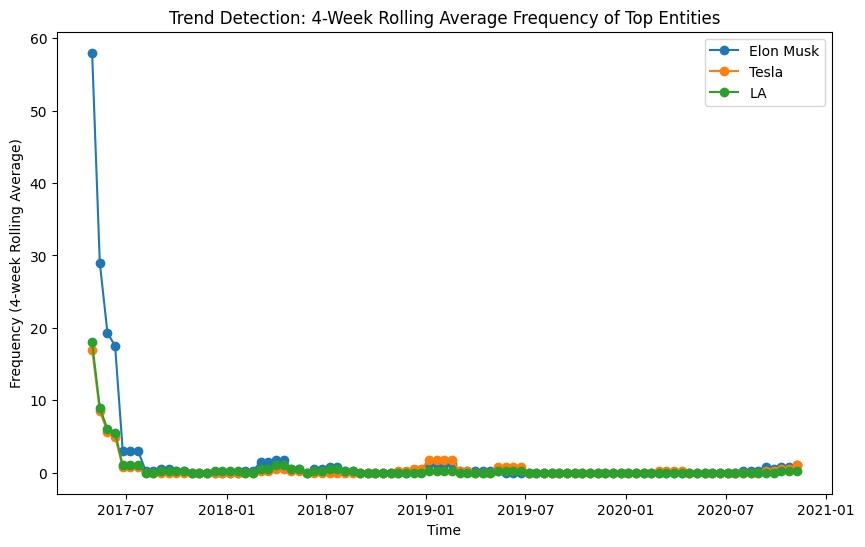

In [58]:
# Group by a weekly time window and by Entity to compute raw counts.
trends = merged_df.groupby([pd.Grouper(key='timestamp', freq='M'), 'Entity'])\
    .size()\
    .reset_index(name='count')

print("Raw weekly counts:")
# display(trends.head(10))

# Pivot the table so that rows are weeks and columns are entities.
pivoted = trends.pivot(index='timestamp', columns='Entity', values='count')
pivoted = pivoted.fillna(0)

# Since weekly grouping is too granular, resample to 2-week intervals (summing counts).
pivoted_2w = pivoted.resample('2W').sum()

print("Pivoted 2-week aggregated table:")
# display(pivoted_2w.head(10))

# Apply a rolling average (window=2) to smooth short-term fluctuations.
rolled = pivoted_2w.rolling(window=4, min_periods=1).mean()

print("4-week rolling average table (2 periods = 4 weeks):")
# display(rolled.head(10))

# Determine the top N entities based on total frequency (summing the 2-week aggregated counts)
top_n = 3
total_counts = pivoted_2w.sum(axis=0)
top_entities = total_counts.nlargest(top_n).index.tolist()

plt.figure(figsize=(10, 6))
for entity in top_entities:
    plt.plot(rolled.index, rolled[entity], marker='o', label=entity)
plt.xlabel("Time")
plt.ylabel("Frequency (4-week Rolling Average)")
plt.title("Trend Detection: 4-Week Rolling Average Frequency of Top Entities")
plt.legend()
plt.show()

Pivoted monthly frequency table:


/var/folders/32/prrr6jy96jn98bdhsgrq6pqm0000gn/T/ipykernel_10618/1403786794.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  trends_monthly = merged_df.groupby([pd.Grouper(key='timestamp', freq='M'), 'Entity']).size().reset_index(name='count')


Entity,100k,100s,200k,>.>,A COMPLETE CHAOS,A30,ADDITION,AI,APPARATUS,ASAP,...,😏,😜,😩😩💦,😪,😶,🙁,🚗,🚫🚫🚫🚫🚫,🤔,🤯
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-04-30 00:00:00+00:00,1.0,1.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0
2017-05-31 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2017-06-30 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-07-31 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-31 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-10-31 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-11-30 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-31 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-31 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


3-month rolling average table:


Entity,100k,100s,200k,>.>,A COMPLETE CHAOS,A30,ADDITION,AI,APPARATUS,ASAP,...,😏,😜,😩😩💦,😪,😶,🙁,🚗,🚫🚫🚫🚫🚫,🤔,🤯
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-04-30 00:00:00+00:00,1.0,1.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0
2017-05-31 00:00:00+00:00,1.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,1.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0
2017-06-30 00:00:00+00:00,1.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,1.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0
2017-07-31 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2017-08-31 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-10-31 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-11-30 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-31 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-31 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Top entities: ['Elon Musk', 'Tesla', 'LA']


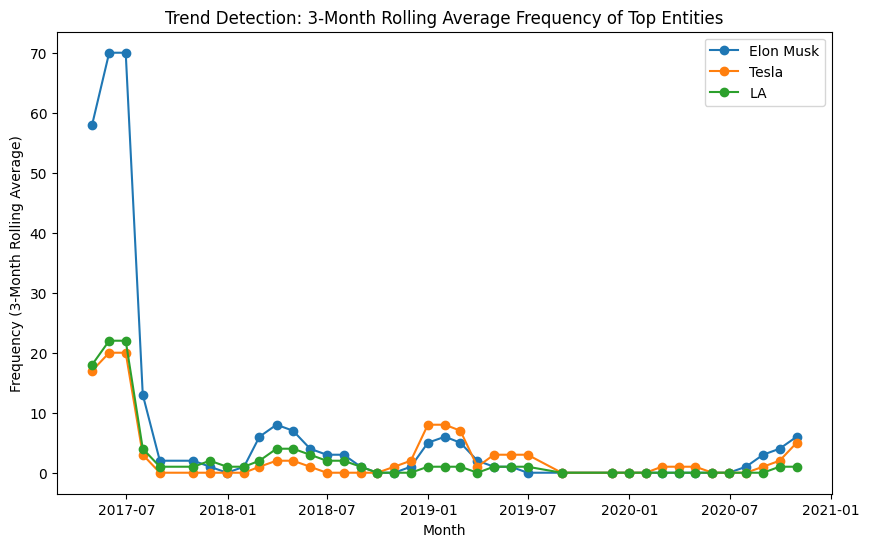

In [59]:
# Group entities by month (using the end-of-month frequency) and by Entity to count mentions.
trends_monthly = merged_df.groupby([pd.Grouper(key='timestamp', freq='M'), 'Entity']).size().reset_index(name='count')

# Pivot the table so that each row represents a month and each column an entity.
pivoted_monthly = trends_monthly.pivot(index='timestamp', columns='Entity', values='count').fillna(0)

print("Pivoted monthly frequency table:")
display(pivoted_monthly.head(10))

# Apply a trailing (non-centered) 3-month rolling average.
rolled_3m = pivoted_monthly.rolling(window=3, min_periods=1).sum()

print("3-month rolling average table:")
display(rolled_3m.head(10))

# Select top N entities based on overall frequency in the monthly data.
top_n = 3
total_counts = pivoted_monthly.sum(axis=0)
top_entities = total_counts.nlargest(top_n).index.tolist()
print("Top entities:", top_entities)

plt.figure(figsize=(10,6))
for entity in top_entities:
    plt.plot(rolled_3m.index, rolled_3m[entity], marker='o', label=entity)
plt.xlabel("Month")
plt.ylabel("Frequency (3-Month Rolling Average)")
plt.title("Trend Detection: 3-Month Rolling Average Frequency of Top Entities")
plt.legend()
plt.show()

Top entities: ['Elon Musk', 'Tesla', 'LA']


/var/folders/32/prrr6jy96jn98bdhsgrq6pqm0000gn/T/ipykernel_10618/506266912.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  trends_monthly = merged_df.groupby([pd.Grouper(key='timestamp', freq='M'), 'Entity']) \


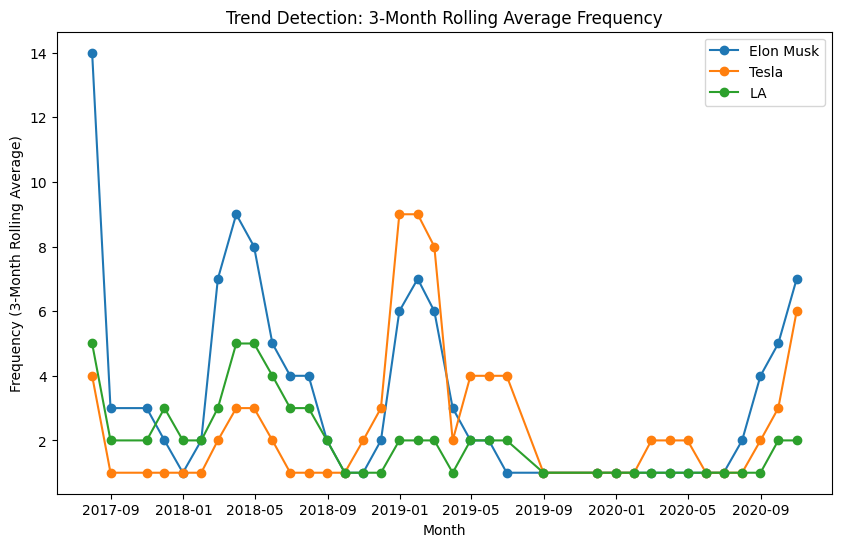

In [103]:
# Group entities by month (using end-of-month frequency) and by Entity to count mentions.
trends_monthly = merged_df.groupby([pd.Grouper(key='timestamp', freq='M'), 'Entity']) \
    .size().reset_index(name='count')

pivoted_monthly = trends_monthly.pivot(index='timestamp', columns='Entity', values='count').fillna(0)
rolled_3m = pivoted_monthly.rolling(window=3, min_periods=1).sum()
rolled_3m = rolled_3m.iloc[3:]

top_n = 3
total_counts = pivoted_monthly.sum(axis=0)
top_entities = total_counts.nlargest(top_n).index.tolist()
print("Top entities:", top_entities)

plt.figure(figsize=(10,6))
for entity in top_entities:
    plt.plot(rolled_3m.index, rolled_3m[entity] + 1, marker='o', label=entity)
plt.xlabel("Month")
plt.ylabel("Frequency (3-Month Rolling Average)")
plt.title("Trend Detection: 3-Month Rolling Average Frequency")
plt.legend()
plt.show()

### Compare to other models

In [89]:
import joblib
model_obj = joblib.load("bert_ner_tokenizer.joblib")
print("Loaded object type:", type(model_obj))

Loaded object type: <class 'transformers.models.bert.tokenization_bert_fast.BertTokenizerFast'>


In [91]:
from transformers import AutoModelForTokenClassification, AutoTokenizer, pipeline

model = AutoModelForTokenClassification.from_pretrained("bert-base-cased")
ner_pipeline = pipeline("ner", model=model, tokenizer=model_obj)

sample_sentence = "I love the new Apple iPhone 13, it's amazing!"
results = ner_pipeline(sample_sentence)
print(results)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use mps:0


[{'entity': 'LABEL_1', 'score': np.float32(0.5062186), 'index': 1, 'word': 'I', 'start': 0, 'end': 1}, {'entity': 'LABEL_0', 'score': np.float32(0.5680411), 'index': 2, 'word': 'love', 'start': 2, 'end': 6}, {'entity': 'LABEL_0', 'score': np.float32(0.5239975), 'index': 3, 'word': 'the', 'start': 7, 'end': 10}, {'entity': 'LABEL_0', 'score': np.float32(0.5424268), 'index': 4, 'word': 'new', 'start': 11, 'end': 14}, {'entity': 'LABEL_0', 'score': np.float32(0.5396143), 'index': 5, 'word': 'Apple', 'start': 15, 'end': 20}, {'entity': 'LABEL_0', 'score': np.float32(0.5401536), 'index': 6, 'word': 'iPhone', 'start': 21, 'end': 27}, {'entity': 'LABEL_0', 'score': np.float32(0.5286338), 'index': 7, 'word': '13', 'start': 28, 'end': 30}, {'entity': 'LABEL_0', 'score': np.float32(0.6042892), 'index': 8, 'word': ',', 'start': 30, 'end': 31}, {'entity': 'LABEL_0', 'score': np.float32(0.5791196), 'index': 9, 'word': 'it', 'start': 32, 'end': 34}, {'entity': 'LABEL_0', 'score': np.float32(0.609001

In [100]:
!python -m spacy download en_core_web_md
import spacy
spacy_nlp = spacy.load("en_core_web_md")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 65.9 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [101]:
# Define your test sentences (you can replace these with your real test data).
X_test = [
    "I love the new Apple iPhone 13, it's amazing!",
    "Samsung is releasing a new phone this fall."
]

# Get predictions from your transformer-based NER pipeline.
# Note: The output from the pipeline is a list of dictionaries for each sentence.
pipeline_preds = [ner_pipeline(sentence) for sentence in X_test]

# Load a baseline spaCy model. (Using en_core_web_md since en_core_web_sm might not have full vectors.)
import spacy
spacy_nlp = spacy.load("en_core_web_md")

# Get predictions from the spaCy baseline.
spacy_preds = []
for sentence in X_test:
    doc = spacy_nlp(sentence)
    # For each sentence, extract a list of (entity text, entity label).
    spacy_preds.append([(ent.text, ent.label_) for ent in doc.ents])

# Print out the results side by side for comparison.
print("Transformer Pipeline Predictions:")
for i, preds in enumerate(pipeline_preds):
    print(f"Sentence {i+1}:")
    for pred in preds:
        print("  ", pred)
    print()

print("SpaCy Baseline Predictions:")
for i, preds in enumerate(spacy_preds):
    print(f"Sentence {i+1}:")
    for pred in preds:
        print("  ", pred)
    print()

Transformer Pipeline Predictions:
Sentence 1:
   {'entity': 'LABEL_1', 'score': np.float32(0.5062186), 'index': 1, 'word': 'I', 'start': 0, 'end': 1}
   {'entity': 'LABEL_0', 'score': np.float32(0.5680411), 'index': 2, 'word': 'love', 'start': 2, 'end': 6}
   {'entity': 'LABEL_0', 'score': np.float32(0.5239975), 'index': 3, 'word': 'the', 'start': 7, 'end': 10}
   {'entity': 'LABEL_0', 'score': np.float32(0.5424268), 'index': 4, 'word': 'new', 'start': 11, 'end': 14}
   {'entity': 'LABEL_0', 'score': np.float32(0.5396143), 'index': 5, 'word': 'Apple', 'start': 15, 'end': 20}
   {'entity': 'LABEL_0', 'score': np.float32(0.5401536), 'index': 6, 'word': 'iPhone', 'start': 21, 'end': 27}
   {'entity': 'LABEL_0', 'score': np.float32(0.5286338), 'index': 7, 'word': '13', 'start': 28, 'end': 30}
   {'entity': 'LABEL_0', 'score': np.float32(0.6042892), 'index': 8, 'word': ',', 'start': 30, 'end': 31}
   {'entity': 'LABEL_0', 'score': np.float32(0.5791196), 'index': 9, 'word': 'it', 'start': 32